# Introduction to Natural Language Processing @ 36c3

Each of these 'cells' contains code which can be executed by selecting the cell and pressing **CTRL + Enter**. If you do not have a keyboard, you can select the cell and press the **Run** button on top.

While there are thousands of things we could do, we will limit ourselves to a couple of simple NLP tasks. First, we will implement some of them in pure Python before moving to spaCy, a very robust and widely used NLP library. The code in this notebook is not optimized/writted for production!

In [14]:
from pathlib import Path
import re
import math
import random
from collections import Counter, defaultdict
from difflib import SequenceMatcher
import matplotlib

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

import gensim

import spacy
from spacy import displacy
import en_core_web_sm

%matplotlib inline

# DIY NLP

## 1. Regular Expressions

In [ ]:
text = 'She also missed her spaceship to school.'

In [ ]:
results = re.findall('[a-zA-Z]{4,}', text)
#results = re.findall('[a-zA-Z]*ed', text)

for r in results:
    print(r)

## 2. Reading and Tokenizing a Corpus

In [3]:
# Read file and skip description; change case to lowercase
with Path('demo-data/BROWN-a1-a44-modified.txt') as corpus_file:
    corpus = corpus_file.read_text()[350:].lower()

In [ ]:
corpus[0:50]

In [4]:
def tokenize(text):
    return re.split('\s+', text)

In [5]:
# Tokenization
tokens = tokenize(corpus)

In [ ]:
tokens

## 3. Frequency List & Vocabulary

In [6]:
def frequency_list(tokens):
    return Counter(tokens)

In [36]:
frequency_list(tokens).most_common()

[('the', 1),
 ('of', 1),
 ('and', 1),
 ('to', 1),
 ('a', 1),
 ('in', 1),
 ('for', 1),
 ('that', 1),
 ('is', 1),
 ('was', 1),
 ('on', 1),
 ('he', 1),
 ('at', 1),
 ('with', 1),
 ('be', 1),
 ('as', 1),
 ('by', 1),
 ('his', 1),
 ('it', 1),
 ('will', 1),
 ('from', 1),
 ('are', 1),
 ('an', 1),
 ('this', 1),
 ('--', 1),
 ('has', 1),
 ('had', 1),
 ('but', 1),
 ('they', 1),
 ('who', 1),
 ('have', 1),
 ('were', 1),
 ('not', 1),
 ('mrs.', 1),
 ('said', 1),
 ('would', 1),
 ('new', 1),
 ('which', 1),
 ('their', 1),
 ('been', 1),
 ('its', 1),
 ('one', 1),
 ('there', 1),
 ('i', 1),
 ('last', 1),
 ('more', 1),
 ('or', 1),
 ('all', 1),
 ('mr.', 1),
 ('two', 1),
 ('when', 1),
 ('other', 1),
 ('up', 1),
 ('after', 1),
 ('first', 1),
 ('about', 1),
 ('out', 1),
 ('than', 1),
 ('state', 1),
 ('also', 1),
 ('president', 1),
 ('no', 1),
 ('into', 1),
 ('over', 1),
 ('her', 1),
 ('some', 1),
 ('home', 1),
 ('only', 1),
 ('we', 1),
 ('made', 1),
 ('if', 1),
 ('three', 1),
 ('what', 1),
 ('any', 1),
 ('under', 

In [126]:
vocabulary = set(tokens)

### Zipf's Law

In [19]:
freqs = []

for i, token in enumerate(frequency_list(tokens).most_common()):
    freqs.append([token[0], i, token[1], math.log(token[1]), len(token[0])])

df = pd.DataFrame.from_records(freqs, columns=['wordform', 'rank', 'frequency', 'logfrequency', 'length'])

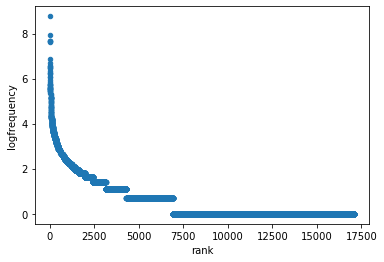

In [33]:
df.plot(kind='scatter', y='logfrequency', x='rank')

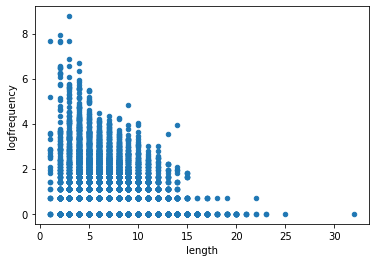

In [31]:
df.plot(kind='scatter', y='logfrequency', x='length')

## 4. N-Grams

In [ ]:
def n_grams(tokens, n):
    n_grams = zip(*[tokens[i:] for i in range(n)])
    return [n_gram for n_gram in n_grams]

In [ ]:
n_grams(tokens, 3)

## 5. A Very Simple N-Gram (Trigram) Language Model

The goal is to predict the/a next word in a sequence of words. We will be implementing the most basic (n-gram-based) language model possible.

In [ ]:
trigrams = n_grams(tokens, 3)
model = defaultdict(lambda: defaultdict(lambda: 0))

for t0, t1, t2 in trigrams:
    model[(t0, t1)][t2] += 1

In [ ]:
model['i', 'have']

In [ ]:
for t0t1 in model:
    count = float(sum(model[t0t1].values()))
    for t2 in model[t0t1]:
        model[t0t1][t2] /= count

In [ ]:
model['and', 'we']

### 4.1 Generate Text

In [ ]:
def generate_text(model, starting_tokens, max_length, threshold=0.1, verbose=False):
    
    text = starting_tokens
    
    while not len(text) > max_length:
        candidates = []
        for token in model[tuple(text[-2:])].keys():
            if model[tuple(text[-2:])][token] >= threshold:
                candidates.append(token)
        
        try:
            random_candidate = random.choice(candidates)              
            text.append(random_candidate)
            
            if verbose:
                print(f'* "{" ".join(text)}" could be continued with {candidates} --> {random_candidate}')
            
        except IndexError:
            # There are no valid candidates anymore
            break
                
        
    return text

In [ ]:
generate_text(model, ['the', 'person'], 5, 0.05, verbose=False)

### 4.2 Crude Spelling Correction

#### a) Vocabulary Approach

In [ ]:
def find_closest_match(vocabulary, search):
    best_match = [0, '']
    
    for word in vocabulary:
        ratio = SequenceMatcher(None, search, word).ratio()
        if ratio > best_match[0]:
            best_match = [ratio, word]
            
    return best_match
        

In [ ]:
find_closest_match(vocabulary, 'girk')

In [ ]:
def correct_vocab_approach(text):
    wrong = tokenize(text.lower())
    corrected = []

    for token in wrong:
        if token in vocabulary:
            corrected.append(token)
        else:
            corrected.append(find_closest_match(vocabulary, token)[1])
    
    return ' '.join(corrected)

#### b) Vocabulary & Model Appproach

In [ ]:
def correct_vocabmodel_approach(model, text):
    wrong = tokenize(text.lower())
    corrected = []

    for i, token in enumerate(wrong):
        if token in vocabulary:
            corrected.append(token)
        else:
            candidates = list(model[(wrong[i-2], wrong[i-1])])
            if len(candidates) > 0:
                corrected.append(find_closest_match(candidates, token)[1])
            else:
                corrected.append('X')
                    
    return ' '.join(corrected)

In [ ]:
wrong = 'The man whp had a beautiful cat.'

print(f'Approach A: {correct_vocab_approach(wrong)}')
print(f'Approach B: {correct_vocabmodel_approach(model, wrong)}')

# spaCy

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
example_sentence = nlp('She missed her spaceship to school.')
doc = nlp(corpus)

## 1. Navigating the Doc

By default, spaCy runs a number of taggers and parsers. Hence, our *doc* now contains much more information than just the raw text.

In [ ]:
sentences = list(doc.sents)

In [ ]:
for token in sentences[0]:
    print(f'{token.text} ({token.lemma_}) is a {token.pos_}/{token.tag_}')

## 2. Part-of-Speech Tagging

In [ ]:
for token in example_sentence:
    print(token, token.pos_)

## 3. Depedency Parsing / Universal Dependencies

In [ ]:
for token in example_sentence:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

In [ ]:
displacy.render(example_sentence, style='dep')

## 4. Named Entity Recognition (NER)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
displacy.render(doc, style='ent')

# Vectorization and Word2Vec

## 1. CountVectorizer

In [ ]:
corpus = [
            'She missed her spaceship to school.',
            'The spaceship usually is a little bit late.'
         ]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray())

In [ ]:
vectorizer.get_feature_names()

## 2. Word2Vec

In [ ]:
w2v_sentences = []
for sentence in sentences:
    w2v_sentences.append([token.text for token in sentence])
    
w2v_sentences[0:2]

In [ ]:
model = gensim.models.Word2Vec(w2v_sentences)

In [ ]:
model.wv.vocab

In [ ]:
model.similarity('the', 'a')

Let's play with a pre-trained model...

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-ruscorpora-300') # Russian National Corpus

In [ ]:
wv.vocab

In [ ]:
wv.most_similar(positive='город_NOUN') # город = city